# Section 2: **Dataset Overview**

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import statsmodels.api as sm

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Configuration and Data Loading
DATASET_DIR = Path(r"E:\EDA_chess_data\processed")
df_games = pd.DataFrame() # Initialize empty DataFrame
df_game_lengths = pd.Series(dtype='float64') # Initialize empty Series
time_control_counts = pd.Series(dtype='int64') # Initialize empty Series

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
try:
    # Specify only the columns needed for this section's analysis
    columns_to_load = ['GameID', 'WhiteElo', 'BlackElo', 'TimeControl', 'Ply', 'Year', 'Termination', 'Result']
    filters = None

    df_moves = pd.read_parquet(
        DATASET_DIR,
        columns=columns_to_load,
        filters=filters,
        engine='pyarrow'
    )
    print(f"Successfully loaded {len(df_moves)} moves initially.")

    # Create DataFrame representing unique games
    print("Extracting unique games...")
    df_games = df_moves[['GameID', 'WhiteElo', 'BlackElo', 'TimeControl', 'Year', 'Termination', 'Result']].drop_duplicates(subset=['GameID'])
    print(f"Found {len(df_games)} unique games.")

    # Create Series for Game Lengths
    print("Calculating game lengths...")
    df_moves['Ply'] = pd.to_numeric(df_moves['Ply'], errors='coerce')
    df_game_lengths = df_moves.dropna(subset=['GameID', 'Ply']).groupby('GameID')['Ply'].max()
    print(f"Calculated lengths for {len(df_game_lengths)} unique games.")

    # Analyze Raw Time Controls
    time_control_counts = df_games['TimeControl'].astype(str).value_counts()

    print("Dataset sample (Unique Games):")
    print(df_games.head())

except FileNotFoundError:
    print(f"ERROR: Dataset directory not found at {DATASET_DIR}. Please check the path.")
except Exception as e:
    print(f"An error occurred during data loading or initial processing: {e}")


Successfully loaded 10593734 moves initially.
Extracting unique games...
Found 159669 unique games.
Calculating game lengths...
An error occurred during data loading or initial processing: Unable to allocate 242. MiB for an array with shape (3, 10593734) and data type int64


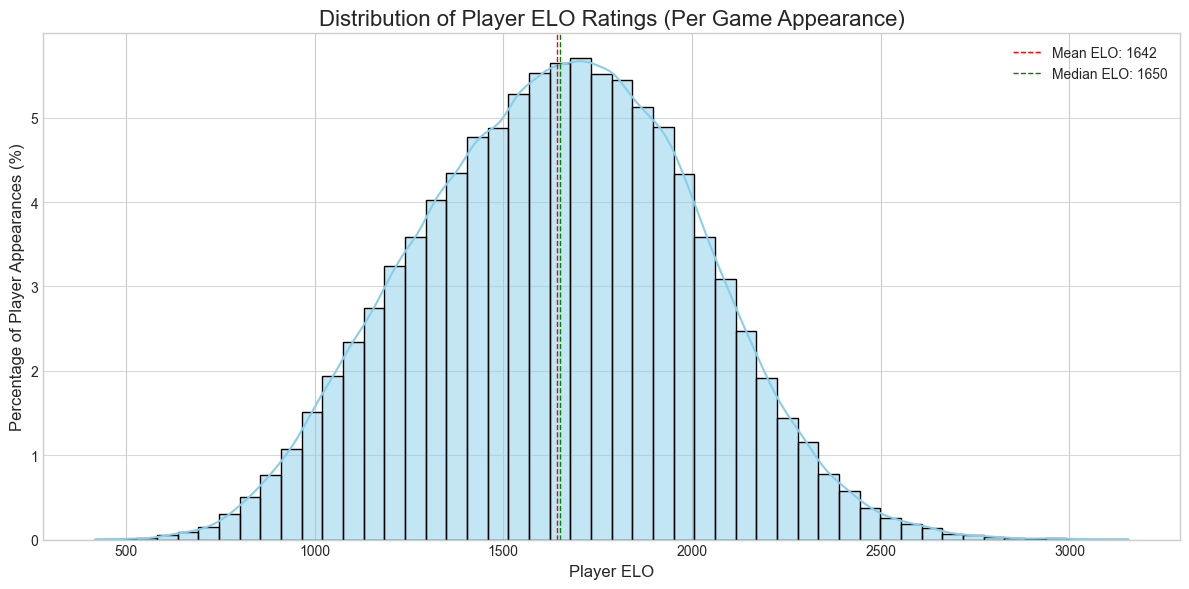

Skewness of ELO distribution: 0.00


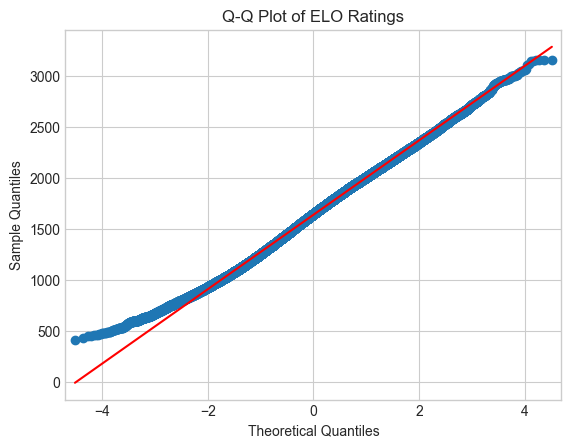

In [3]:
# Graph 1: Distribution of Player ELO Ratings (Percentage)

if not df_games.empty:
    elos_per_game_appearance = pd.concat([df_games['WhiteElo'], df_games['BlackElo']])
    elos_per_game_appearance = elos_per_game_appearance[elos_per_game_appearance != 1500].dropna().astype(int)

    plt.figure(figsize=(12, 6))
    # Use stat='percent' to normalize the histogram
    sns.histplot(elos_per_game_appearance, bins=50, kde=True, color='skyblue', stat='percent')
    plt.title('Distribution of Player ELO Ratings (Per Game Appearance)', fontsize=16)
    plt.xlabel('Player ELO', fontsize=12)
    # Update Y-axis label
    plt.ylabel('Percentage of Player Appearances (%)', fontsize=12)
    plt.grid(axis='y', alpha=0.75)

    # Keep mean/median lines for context relative to the distribution shape
    mean_elo = elos_per_game_appearance.mean()
    median_elo = elos_per_game_appearance.median()
    skewness = elos_per_game_appearance.skew() # Calculate skewness

    plt.axvline(mean_elo, color='red', linestyle='dashed', linewidth=1, label=f'Mean ELO: {mean_elo:.0f}')
    plt.axvline(median_elo, color='green', linestyle='dashed', linewidth=1, label=f'Median ELO: {median_elo:.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Skewness of ELO distribution: {skewness:.2f}") # Print skewness

if not df_games.empty:
    elos_per_game_appearance = pd.concat([df_games['WhiteElo'], df_games['BlackElo']])
    elos_per_game_appearance = elos_per_game_appearance[elos_per_game_appearance != 1500].dropna().astype(int)

    sm.qqplot(elos_per_game_appearance, line='s')  # 's' for standardized line
    plt.title('Q-Q Plot of ELO Ratings')
    plt.show()

else:
    print("Skipping ELO distribution plot due to data loading issues.")

**Graph 1 Interpretation:** Excluding the default 1500 rating, the histogram reveals a nearly symmetrical distribution centered around the mid-1600s, with a slight visual skew. The Q-Q plot further elucidates that the central region of the data closely follows a normal distribution, while the tails show slight deviations. The significant deviation in the lower tail is explained by the 400 ELO minimum on Lichess, which truncates the distribution at this point. The low skewness value of 0.01 is consistent with the Q-Q plot's observation of a predominantly normal distribution with minor tail deviations, especially when the 400 ELO minimum is taken into consideration.

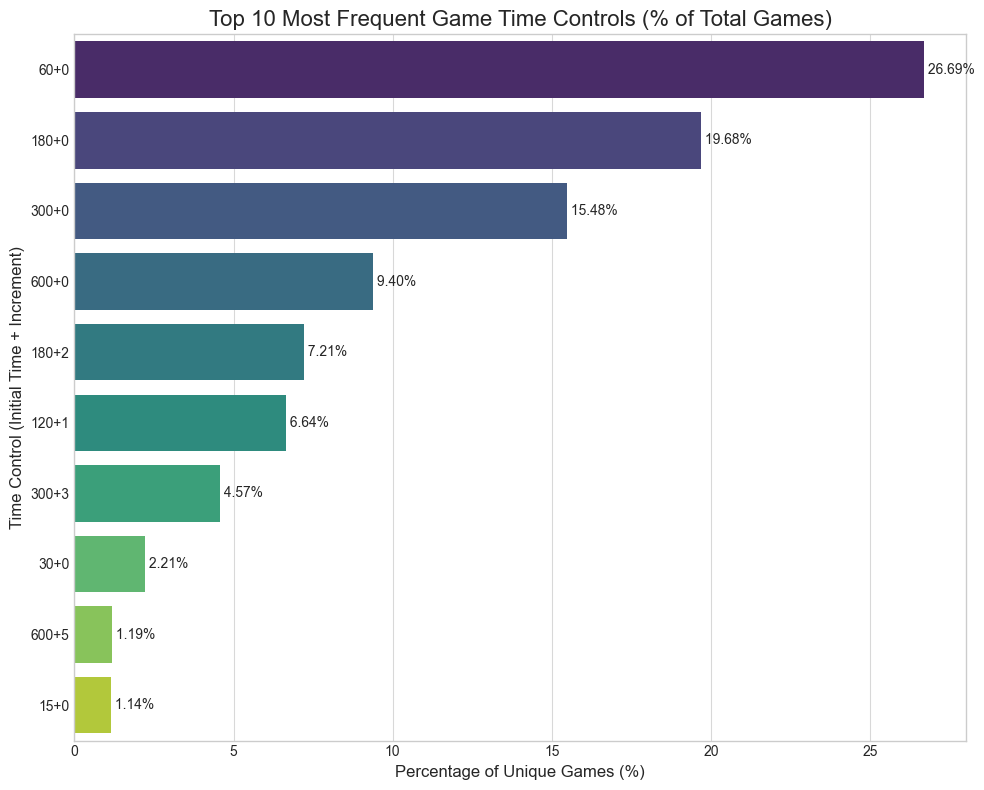

In [4]:
# Graph 2: Distribution of Top Time Controls (Percentage)

if not df_games.empty and 'TimeControl' in df_games.columns:
    top_n = 10
    time_control_counts = df_games['TimeControl'].astype(str).value_counts()
    frequent_time_controls = time_control_counts.head(top_n)

    # Calculate total games for percentage calculation
    total_games = len(df_games)

    # Calculate percentage
    percentages = (frequent_time_controls / total_games) * 100

    plt.figure(figsize=(10, 8))
    # Plot percentages on the x-axis
    sns.barplot(x=percentages.values, y=percentages.index, hue=percentages.index, palette='viridis', orient='h', legend=False)  # Updated line

    plt.title(f'Top {top_n} Most Frequent Game Time Controls (% of Total Games)', fontsize=16)
    # Update X-axis label
    plt.xlabel('Percentage of Unique Games (%)', fontsize=12)
    plt.ylabel('Time Control (Initial Time + Increment)', fontsize=12)
    plt.grid(axis='x', alpha=0.75)

    # Optional: Add percentage labels to bars
    for index, value in enumerate(percentages):
        plt.text(value, index, f' {value:.2f}%', va='center')

    plt.tight_layout()
    plt.show()
else:
    print("No time controls found or df_games empty, skipping plot.")

**Graph 2 Interpretation:** This bar chart displays the frequency of the most common time controls counted per unique game in the dataset. The most played time controls are 1+0 bullet, 3+0 blitz, 5+0 blitz, and 10+0 rapid.

In [5]:
# Graph 3: Distribution of Game Length (Percentage)

if not df_game_lengths.empty:
    plt.figure(figsize=(12, 6))
    # Use stat='percent' to normalize the histogram
    sns.histplot(df_game_lengths, bins=77, kde=True, color='purple', stat='percent')
    plt.title('Distribution of Game Lengths (in Plies)', fontsize=16)
    plt.xlabel('Game Length (Number of Plies)', fontsize=12)
    # Update Y-axis label
    plt.ylabel('Percentage of Games (%)', fontsize=12)
    plt.grid(axis='y', alpha=0.75)

    # Keep mean/median lines for context relative to the distribution shape
    mean_len = df_game_lengths.mean()
    median_len = df_game_lengths.median()
    plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean Length: {mean_len:.0f} ply')
    plt.axvline(median_len, color='green', linestyle='dashed', linewidth=1, label=f'Median Length: {median_len:.0f} ply')
    plt.legend()
    # plt.xlim(0, df_game_lengths.quantile(0.99)) # Limit x-axis if needed
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Game Length distribution plot due to data loading/processing issues.")

Skipping Game Length distribution plot due to data loading/processing issues.


**Graph 3 Interpretation:** Game lengths are concentrated around 50-65 plies. The distribution is right-skewed, reflected in the mean (65 plies) and median (61 plies). There is a long tail extending to the right.

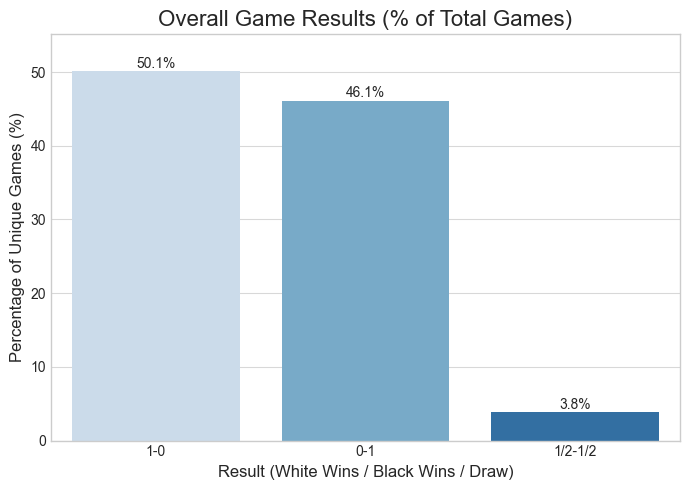

In [6]:
# Graph 4: Overall Game Results (Percentage)

if not df_games.empty and 'Result' in df_games.columns:
    result_counts = df_games['Result'].value_counts(normalize=True) * 100  # Get percentages directly

    # Filter for standard results if needed (optional)
    standard_results = ['1-0', '0-1', '1/2-1/2']
    result_percentages = result_counts[result_counts.index.isin(standard_results)]

    plt.figure(figsize=(7, 5))
    sns.barplot(x=result_percentages.index, y=result_percentages.values, hue=result_percentages.index, palette='Blues', legend=False)  # Updated line
    plt.title('Overall Game Results (% of Total Games)', fontsize=16)
    plt.xlabel('Result (White Wins / Black Wins / Draw)', fontsize=12)
    plt.ylabel('Percentage of Unique Games (%)', fontsize=12)
    plt.ylim(0, max(result_percentages.values) * 1.1)  # Adjust y-limit for labels
    plt.grid(axis='y', alpha=0.75)

    # Add percentage labels
    for i, val in enumerate(result_percentages.values):
        plt.text(i, val + 0.5, f'{val:.1f}%', ha='center')  # Adjust vertical offset if needed

    plt.tight_layout()
    plt.show()
else:
    print("Skipping game results plot ('Result' column missing or df_games empty).")

**Graph 4 Interpretation:** White tends to win more often than black because of the first-move advantage.

In [7]:
if 'df_games' in locals() and not df_games.empty:
    print(f"Total Unique Games Processed: {len(df_games)}")

if 'df_moves' in locals() and not df_moves.empty:
    print(f"Total Moves: {len(df_moves)}")

if 'elos_per_game_appearance' in locals() and not elos_per_game_appearance.empty:
    print(f"ELO Range Observed: {int(elos_per_game_appearance.min())} to {int(elos_per_game_appearance.max())}")

Total Unique Games Processed: 159669
Total Moves: 10593734
ELO Range Observed: 418 to 3156
